In [20]:
import torch
import torch.nn as nn
import torch.optim as optim 
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.datasets as datasets

import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [5]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [50]:
train_path = "train"
val_path = "val"

train = datasets.DatasetFolder(root=train_path, 
                               loader=torchvision.datasets.folder.default_loader, 
                               extensions=['.jpg', '.jpeg'],
                               transform=transform)

val = datasets.DatasetFolder(root=val_path, 
                               loader=torchvision.datasets.folder.default_loader,
                               extensions=['.jpg', '.jpeg'],
                               transform=transform)

In [51]:
type(train)

torchvision.datasets.folder.DatasetFolder

torch.Size([3, 224, 224]) 0


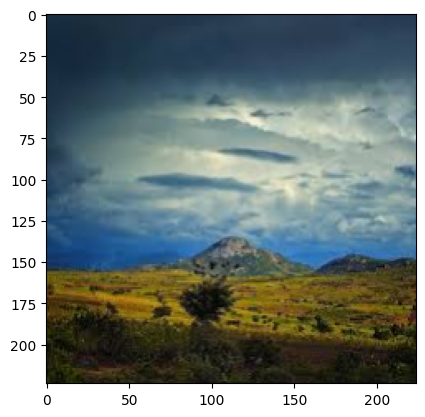

In [52]:
inp, lab = next(iter(train))
print(inp.shape, lab)
plt.imshow(inp.numpy().transpose(1, 2, 0))

In [33]:
#Set up the dataloaders
train_loader = torch.utils.data.DataLoader(train, batch_size=12, shuffle=True)
val_loader = torch.utils.data.DataLoader(val, batch_size=20, shuffle=True)

In [45]:
resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
resnet.fc = nn.Linear(2048, 2)
resnet = resnet.to(device)

#Set all layers to not trainable
for param in resnet.parameters():
    param.requires_grad = False

#Set the last layer to require grad
for param in resnet.fc.parameters():
    param.requires_grad = True

resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [46]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet.parameters(), lr=0.001)
metrics = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

In [47]:
total_epochs = 10
for epoch in range(total_epochs):
    resnet.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = resnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    metrics['train_loss'].append(running_loss / len(train_loader))
    metrics['train_acc'].append(correct / total)
    
    resnet.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = resnet(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    metrics['val_loss'].append(running_loss / len(val_loader))
    metrics['val_acc'].append(correct / total)
    
    print(f"Epoch {epoch + 1}/{total_epochs} Train Loss: {metrics['train_loss'][-1]:.4f} Train Acc: {metrics['train_acc'][-1]:.4f} Val Loss: {metrics['val_loss'][-1]:.4f} Val Acc: {metrics['val_acc'][-1]:.4f}")

Epoch 1/10 Train Loss: 0.6952 Train Acc: 0.5139 Val Loss: 0.6418 Val Acc: 0.7000
Epoch 2/10 Train Loss: 0.6797 Train Acc: 0.5833 Val Loss: 0.6405 Val Acc: 0.7000
Epoch 3/10 Train Loss: 0.6619 Train Acc: 0.7083 Val Loss: 0.6294 Val Acc: 0.7000
Epoch 4/10 Train Loss: 0.6380 Train Acc: 0.7639 Val Loss: 0.6141 Val Acc: 0.7500
Epoch 5/10 Train Loss: 0.6281 Train Acc: 0.8056 Val Loss: 0.6001 Val Acc: 0.8000
Epoch 6/10 Train Loss: 0.6135 Train Acc: 0.8194 Val Loss: 0.5920 Val Acc: 0.8000
Epoch 7/10 Train Loss: 0.5978 Train Acc: 0.8750 Val Loss: 0.5864 Val Acc: 0.8500
Epoch 8/10 Train Loss: 0.5943 Train Acc: 0.8889 Val Loss: 0.5761 Val Acc: 0.9000
Epoch 9/10 Train Loss: 0.5753 Train Acc: 0.9167 Val Loss: 0.5655 Val Acc: 0.9000
Epoch 10/10 Train Loss: 0.5540 Train Acc: 0.9444 Val Loss: 0.5542 Val Acc: 0.9000


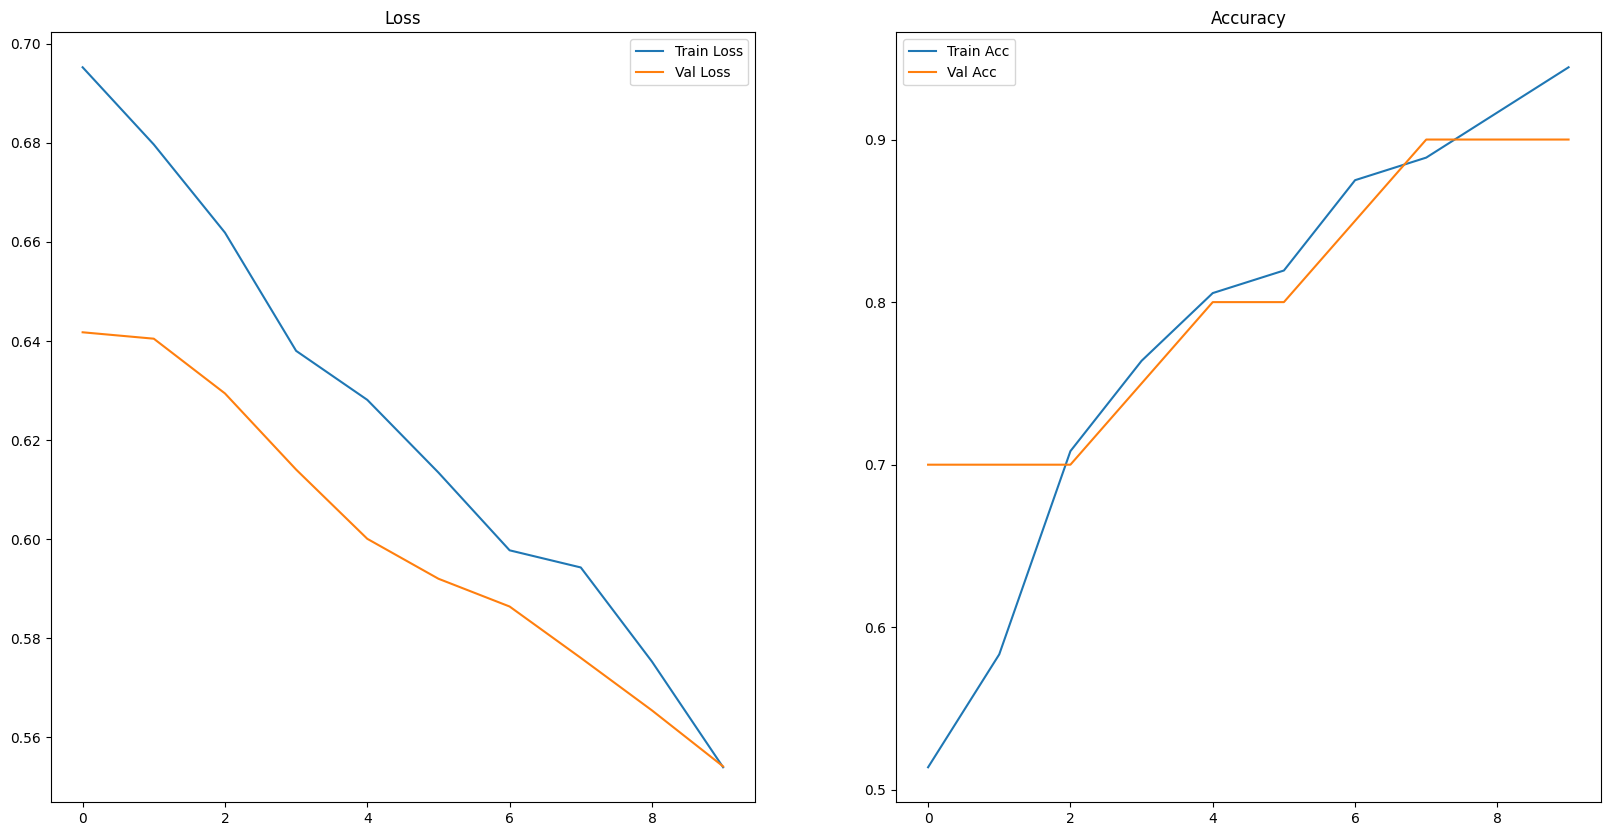

In [49]:
#Plot the metrics
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.plot(metrics['train_loss'], label='Train Loss')
plt.plot(metrics['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')
plt.subplot(1, 2, 2)
plt.plot(metrics['train_acc'], label='Train Acc')
plt.plot(metrics['val_acc'], label='Val Acc')
plt.legend()
plt.title('Accuracy')
plt.show()